**Keyword Clustering**

In SEO, keyword research is beneficial for obtaining relevant keywords to a website. However, its process might come with many tedious and time consuming tasks such as finding keyword data and gathering them in a group.
This projects aims to automate the process of grouping up keywords with great semantic similarity for automating the task of keyword clustering. This is performed by KMeans Clustering that would group keywords and find a topic for each cluster.

Implementation steps:
1) Exploratory Data Analysis
2) Data Processing
3) Dimensionality Reduction
4) Kmeans cluster model: divide keywords into group
5) Finding the topic keyword to represent each cluster

Importing Libraries

In [77]:
# importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt

import warnings
warnings.filterwarnings('ignore')

from wordcloud import WordCloud, STOPWORDS
import re, string, unicodedata
import nltk
#import inflect
from bs4 import BeautifulSoup
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

from nltk.stem import WordNetLemmatizer
#nltk.download('wordnet')
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
import string
string.punctuation
#nltk.download('omw-1.4')
from nltk.tokenize import TweetTokenizer
import nltk
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity


%matplotlib inline
sns.set()

In [78]:
data = pd.read_csv('societyone_keywords.csv')

In [79]:
data[:5]

,Keyword,Position,Previous position,Search Volume,Keyword Difficulty,CPC,URL,Traffic,Traffic (%),Traffic Cost,Competition,Number of Results,Trends,Timestamp,SERP Features by Keyword,Keyword Intents,Position Type
0,20000 loan,5,5,140,15,6.53,https://societyone.com.au/pce-20000-loan,3,0.02,19.0,0.58,151000000,"[52,80,80,66,66,66,66,66,80,52,80,100]",2024-10-12,"Reviews, People also ask, Related searches",informational,Organic
1,best line of credit australia,5,5,40,17,2.59,https://societyone.com.au/pce-best-line-of-cre...,1,0.00,2.0,0.54,380000000,"[77,100,77,22,22,22,22,22,22,22,22,22]",2024-10-18,"Sitelinks, Reviews, People also ask, Related s...",commercial,Organic
2,car title loans australia,5,5,50,3,3.10,https://societyone.com.au/pce-car-title-loans-...,1,0.00,3.0,0.63,5420000,"[9,9,6,6,9,15,6,5,5,4,2,2]",2024-10-17,"Sitelinks, Reviews, People also ask, Related s...",informational,Organic
3,loan against car and still drive it,5,5,210,1,2.61,https://societyone.com.au/pce-loans-against-ca...,5,0.04,13.0,0.74,142000000,"[54,66,54,54,8,54,54,54,43,35,22,29]",2024-10-28,"Sitelinks, Reviews, People also ask, Related s...",commercial,Organic
4,20k loan,5,5,110,26,7.60,https://societyone.com.au/pce-20000-loan,2,0.01,15.0,0.77,119000000,"[82,64,64,64,64,64,82,64,82,64,64,64]",2024-10-20,"Image pack, Sitelinks, Reviews, People also as...",informational,Organic


This dataset shows the current keyword metrics for the website societyone.com.au, which is a loan company. For the keyword clustering task we will only focus on the "Keyword" column and train the model to group them up into clusters.

**1) Exploratory Data Analysis**

In [80]:
#check n/a values
data['Keyword'].isna().sum()

0

In [81]:
# Checking for duplicate records
data['Keyword'].duplicated().value_counts()

Keyword
False    1104
True      223
Name: count, dtype: int64

As there are a few duplicated values, we will need to drop the duplicates

In [82]:
#remove duplicate keyword
data = data.drop_duplicates(subset = 'Keyword')

Text(0.5, 1.0, 'Number of Keywords by length')

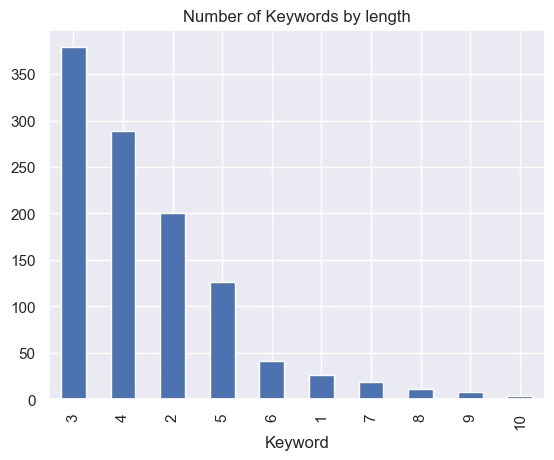

In [83]:
data['Keyword'].apply(lambda x: len(x.split())).value_counts().plot(kind = 'bar')
plt.title('Number of Keywords by length')

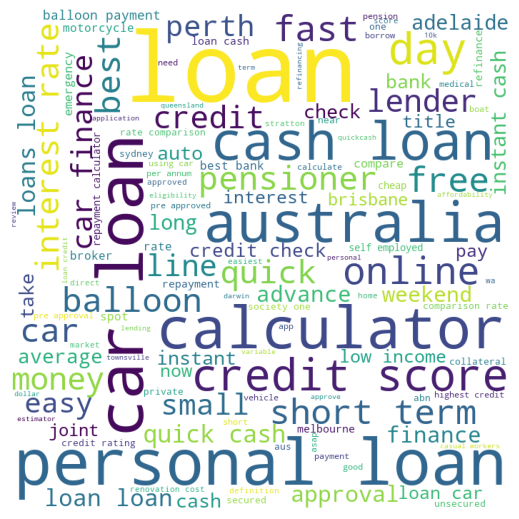

In [84]:
# Building a wordcloud for the keywords
comment_words = ''
stopwords = set(STOPWORDS)

# iterate through the csv file
for val in data.Keyword.values:
    
    # typecaste each val to string
    val = str(val)

    # split the value
    tokens = val.split()
    
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
    
    comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 700, height = 700,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)


# plot the WordCloud image                      
plt.figure(figsize = (10,5), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

Some keywords that appear most frequently are: loan, car loan, credit score, pensioner, cash loan, etc.

**2) Text Data Processing**

Steps: 
- Text preprocesing: remove non-ascii, stop words, punctuation, lowercase
- Lemmatization
- Tokenization
- Word vectorization
- Dimensionality reduction
- build cluster (k-means)

In [85]:
#Text preprocessing
# function to remove non-ascii characters
def remove_non_ascii(words):
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

In [86]:
data['Keyword2'] = remove_non_ascii(data['Keyword'])

In [87]:
from nltk.corpus import stopwords

In [88]:
#remove stopwords and lowercase
sw = stopwords.words('english')
# function to remove stop words
def stopwords(text):
    '''a function for removing the stopword'''
    # removing the stop words and lowercasing the selected words
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    # joining the list of words with space separator
    return " ".join(text)

In [89]:
data['Keyword2'] = data['Keyword2'].apply(stopwords)

In [90]:
# function to remove punctuations
def remove_punctuation(text):
    '''a function for removing punctuation'''
    translator = str.maketrans('', '', string.punctuation)
    # return the text stripped of punctuation marks
    return text.translate(translator)

In [91]:
data['Keyword2'] = data['Keyword2'].apply(remove_punctuation)

In [92]:
def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

In [93]:
data['Keyword2'] = lemmatize_verbs(data['Keyword2'])

In [94]:
tokenizer = TweetTokenizer()

In [95]:
#tokenization
data['Keyword2'] = data['Keyword2'].apply(lambda x: tokenizer.tokenize(x))

Vectorization

In [96]:
# clustering tokens saved in a variable
clustering_data = data['Keyword2']
def identity_tokenizer(text):
    return text
tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, stop_words='english', lowercase=False,max_features = 20000)    
X = tfidf.fit_transform(clustering_data)

In [97]:
X = X.toarray()

 **3) Dimensionality reduction**

In [98]:
# using PCA to reduce dimensionality
pca = PCA(random_state=42)
pca.fit(X)

PCA(random_state=42)

Text(0, 0.5, 'cumulative explained variance')

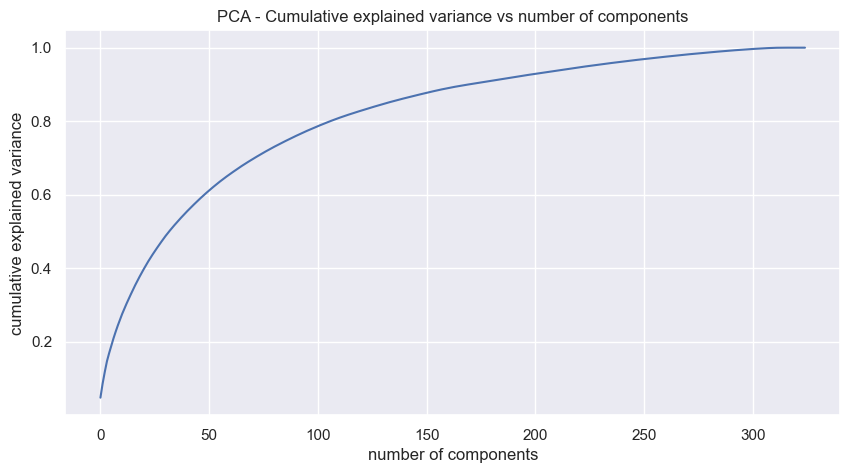

In [99]:
# Explained variance for different number of components
plt.figure(figsize=(10,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('PCA - Cumulative explained variance vs number of components')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [100]:
# reducing the dimensions to 4000 using pca
pca = PCA(n_components=200,random_state=42)
pca.fit(X)

PCA(n_components=200, random_state=42)

In [101]:
# transformed features
x_pca = pca.transform(X)

In [102]:
x_pca.shape

(1104, 200)

**4) K-means clustering**

In this section, we will build a Kmeans clustering model that group the keywords into a cluster based on their distance in word vector

Text(0, 0.5, 'WCSS')

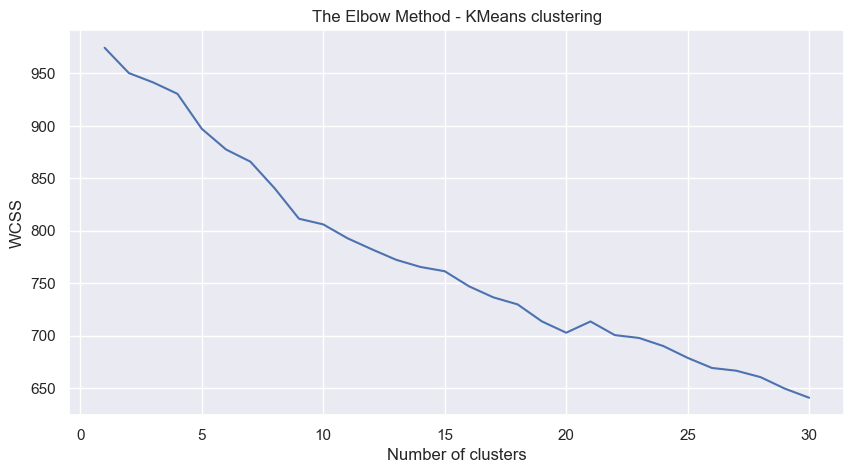

In [103]:
# Elbow method to find the optimal value of k
wcss=[]
for i in range(1,31):
  kmeans = KMeans(n_clusters=i,init='k-means++',random_state=33)
  kmeans.fit(x_pca)
  wcss_iter = kmeans.inertia_
  wcss.append(wcss_iter)

number_clusters = range(1,31)
plt.figure(figsize=(10,5))
plt.plot(number_clusters,wcss)
plt.title('The Elbow Method - KMeans clustering')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

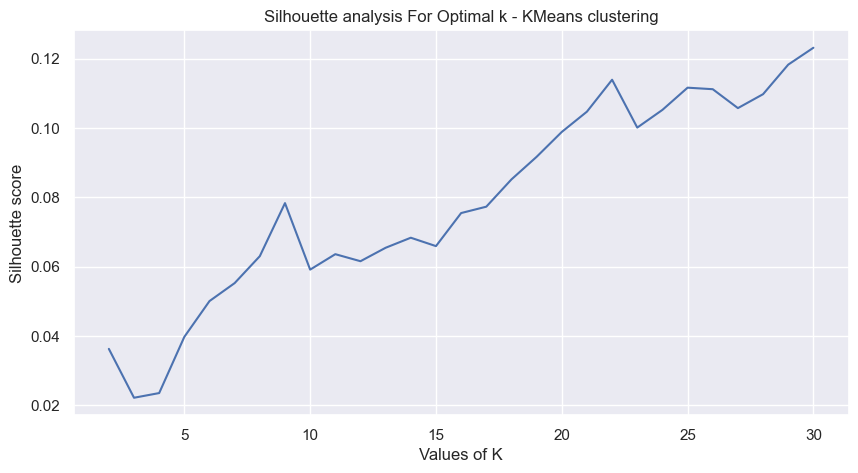

In [104]:
# Plotting Silhouette score for different umber of clusters
range_n_clusters = range(2,31)
silhouette_avg = []
for num_clusters in range_n_clusters:
  # initialize kmeans
  kmeans = KMeans(n_clusters=num_clusters,init='k-means++',random_state=33)
  kmeans.fit(x_pca)
  cluster_labels = kmeans.labels_
 
  # silhouette score
  silhouette_avg.append(silhouette_score(x_pca, cluster_labels))

plt.figure(figsize=(10,5))
plt.plot(range_n_clusters,silhouette_avg)
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score')
plt.title('Silhouette analysis For Optimal k - KMeans clustering')
plt.show()

As silhouette score is very high when the number of cluster is k = 23, we will specify the number of clusters as 23 in our model

In [105]:
# Clustering the data into 23 clusters
kmeans = KMeans(n_clusters=23,init='k-means++',random_state=33)
kmeans.fit(x_pca)

KMeans(n_clusters=23, random_state=33)

In [106]:
# Evaluation metrics 
kmeans_distortion = kmeans.inertia_
kmeans_silhouette_score = silhouette_score(x_pca, kmeans.labels_)

print((kmeans_distortion,kmeans_silhouette_score))

(697.7654618194204, 0.10013202245851469)


In [107]:
# Adding a kmeans cluster number attribute
data['kmeans_cluster'] = kmeans.labels_

In [108]:
result = data[['kmeans_cluster','Keyword']]

In [116]:
# Building a wordcloud for the keywords
def kmeans_worldcloud(cluster_num):
  keywords = ''
  stopwords = set(STOPWORDS)

  # iterate through the csv file
  for val in data[data['kmeans_cluster']==cluster_num].Keyword.values:
      
      # typecaste each val to string
      val = str(val)

      # split the value
      tokens = val.split()
      
      # Converts each token into lowercase
      for i in range(len(tokens)):
          tokens[i] = tokens[i].lower()
      
      keywords += " ".join(tokens)+" "

  wordcloud = WordCloud(width = 500, height = 500, stopwords = stopwords,background_color='white').generate(keywords)


  # plot the WordCloud image                      
  plt.figure(figsize = (10,5))
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout(pad = 0)

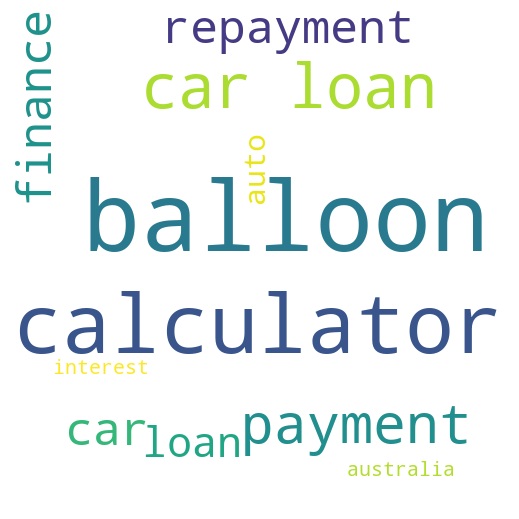

In [117]:
# Wordcloud for cluster 0
kmeans_worldcloud(0)

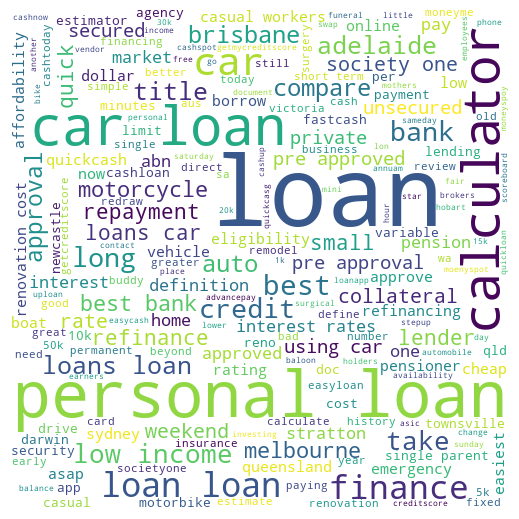

In [118]:
# Wordcloud for cluster 1
kmeans_worldcloud(1)

In [119]:
#save the result
result = result.sort_values(by = 'kmeans_cluster')

**5) Finding the topic keyword to represent each cluster**

In [120]:
cluster_topic = {}

# Load the BERT model for embedding
model = SentenceTransformer('all-MiniLM-L6-v2')  # Or another model if preferred

# Step 1: Generate embeddings for each keyword
keywords = data['Keyword'].values
embeddings = model.encode(keywords)

# Step 2: Cluster the embeddings
n_clusters = 23  # Define the number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(embeddings)

# Add the cluster labels to the data
data['Cluster'] = clusters
data['Embedding'] = list(embeddings)  # Save embeddings for further use

# Step 3: Identify one representative keyword for each cluster
for cluster_id in range(n_clusters):
    # Filter the data to get keywords and embeddings for the current cluster
    cluster_data = data[data['Cluster'] == cluster_id]
    cluster_keywords = cluster_data['Keyword'].values
    cluster_embeddings = np.array(cluster_data['Embedding'].tolist())
    
    # Calculate the mean embedding for the cluster
    cluster_mean_embedding = cluster_embeddings.mean(axis=0)
    
    # Calculate cosine similarity between each keyword's embedding and the cluster mean
    similarities = cosine_similarity([cluster_mean_embedding], cluster_embeddings)[0]
    top_index = similarities.argmax()  # Get index of the closest keyword to the centroid

    # Display the single most representative keyword as the "topic" for each cluster
    top_keyword = cluster_keywords[top_index]
    print(f"Cluster {cluster_id} Topic Keyword: {top_keyword}")
    cluster_topic[cluster_id] = top_keyword

Cluster 0 Topic Keyword: 20000 car loan
Cluster 1 Topic Keyword: quick cash loans
Cluster 2 Topic Keyword: car loan interest rate comparison
Cluster 3 Topic Keyword: car loan calculator with balloon
Cluster 4 Topic Keyword: loans sydney
Cluster 5 Topic Keyword: calculate credit score
Cluster 6 Topic Keyword: same day loans
Cluster 7 Topic Keyword: loans for pensioners
Cluster 8 Topic Keyword: free credit score check online
Cluster 9 Topic Keyword: personal loan best bank
Cluster 10 Topic Keyword: car title loans
Cluster 11 Topic Keyword: cash quick
Cluster 12 Topic Keyword: loan asap
Cluster 13 Topic Keyword: perth car loans
Cluster 14 Topic Keyword: beyond bank loan calculator
Cluster 15 Topic Keyword: private personal loans
Cluster 16 Topic Keyword: per annum
Cluster 17 Topic Keyword: 1000 loan
Cluster 18 Topic Keyword: loans against car
Cluster 19 Topic Keyword: personal loan pre approval
Cluster 20 Topic Keyword: line of credit
Cluster 21 Topic Keyword: how long does it take for lo

In [121]:
result['topic'] = result['kmeans_cluster'].map(cluster_topic)

In [122]:
result

,kmeans_cluster,Keyword,topic
309,0,balloon repayment calculator,20000 car loan
1215,0,balloon payment calculator,20000 car loan
354,0,car loan repayment with balloon calculator,20000 car loan
713,0,car balloon finance calculator,20000 car loan
898,0,finance calculator with balloon,20000 car loan
...,...,...,...
326,22,short term loans australia,melbourne loans
999,22,fast short term loans,melbourne loans
1295,22,short term cash loans,melbourne loans
868,22,short term loan,melbourne loans


In [123]:
result[['kmeans_cluster','topic','Keyword']].rename(columns = {'kmeans_cluster':'group'}).to_csv('Result.csv',index = False)